# Sequential probability ratio test for simple random samples

We use the sequential testing procedure from Weiss (1962). To test the null hypothesis that a multinomial random variable has equal category probabilities $1/k$, we instead conduct a binomial SPRT for modified hypotheses. Fix some integer $s<k$ and let $p_0 = s/k$. Let $p$ denote the probability that the sample is from one of the $s$ most frequent categories. We test

$$H_0: p = p_0 \text{ against } H_1: p = p_1 > p_0.$$

After the $N$th draw from the distribution, we determine which $s$ categories occurred most frequently among the first $N-1$ draws. We say that the event occurs if the $N$th draw is among these categories.


## Simulation parameters

We compare three PRNGs (Mersenne Twister, Super Duper LCG, and SHA-256) and two sampling algorithms (PIKK and sampling by index). Throughout, we use a population of size $n=13$ and draw samples of size $k=3$, for a total of ${13 \choose 3} = 286$ possible multinomial categories. We set $s=10$ and specify $p_1 = 1.1p_0$.

In [1]:
library(dplyr)
library(ggplot2)
options(warn = (-1), message = (-1))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
combinations <- expand.grid(c("MT", "SD", "SHA256"),
                            c("PIKK", "sbi"))

rawdatafiles <- list.files("../rawdata/")

res <- lapply(1:nrow(combinations), function(index){
  filename <- paste0(combinations[index, 1],
                     "_multinomial_", combinations[index, 2], ".csv")
  if(!(filename %in% rawdatafiles)){ return()}
  
  tmp <- read.csv(paste0("../rawdata/", filename), header = TRUE)
  tmp$PRNG <- rep(combinations[index, 1], nrow(tmp))
  tmp$algorithm <- rep(combinations[index, 2], nrow(tmp))
  return(tmp)
})
res <- do.call(rbind, res)

In [3]:
head(res)
str(res)

prng,algorithm,seed,decision,LR,pvalue,steps,n,k,s,PRNG
MT,PIKK,739828299,None,6.91691904178e-322,1,10000000,13,3,10,MT
MT,PIKK,3802979302,1,20.9395984905,0.0477564075765,11101,13,3,10,MT
MT,PIKK,2488119888,None,8.30030285013e-322,1,10000000,13,3,10,MT
MT,PIKK,2813529707,None,6.81810591261e-322,1,10000000,13,3,10,MT
MT,PIKK,564698376,1,20.163927635,0.049593512638,7159,13,3,10,MT
MT,PIKK,2114313936,None,6.98114757574e-321,1,10000000,13,3,10,MT


'data.frame':	5021 obs. of  11 variables:
 $ prng     : Factor w/ 4 levels "MT","prng","SD",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ algorithm: Factor w/ 2 levels "PIKK","sbi": 1 1 1 1 1 1 1 1 1 1 ...
 $ seed     : Factor w/ 1001 levels "100187696","1002417794",..: 933 728 382 464 881 284 704 725 485 621 ...
 $ decision : Factor w/ 3 levels "1","decision",..: 3 1 3 3 1 3 3 3 3 3 ...
 $ LR       : Factor w/ 302 levels "1.00295326106e-321",..: 233 147 266 231 125 235 231 23 227 231 ...
 $ pvalue   : Factor w/ 48 levels "0.0454850383703",..: 47 17 47 47 39 47 47 47 47 47 ...
 $ steps    : Factor w/ 48 levels "10000000","10372",..: 1 5 1 1 39 1 1 1 1 1 ...
 $ n        : Factor w/ 2 levels "13","n": 1 1 1 1 1 1 1 1 1 1 ...
 $ k        : Factor w/ 2 levels "3","k": 1 1 1 1 1 1 1 1 1 1 ...
 $ s        : Factor w/ 2 levels "10","s": 1 1 1 1 1 1 1 1 1 1 ...
 $ PRNG     : Factor w/ 3 levels "MT","SD","SHA256": 1 1 1 1 1 1 1 1 1 1 ...


In [4]:
res %>% group_by(PRNG, algorithm) %>% summarise("Rejection rate" = mean(decision == "1"))

PRNG,algorithm,Rejection rate
MT,PIKK,0.04549951
MT,sbi,0.03800000
SD,PIKK,0.04900000
SD,sbi,0.05300000
SHA256,PIKK,0.00000000
SHA256,sbi,0.03200000


In [5]:
rejects <- res %>% filter(decision != "None")

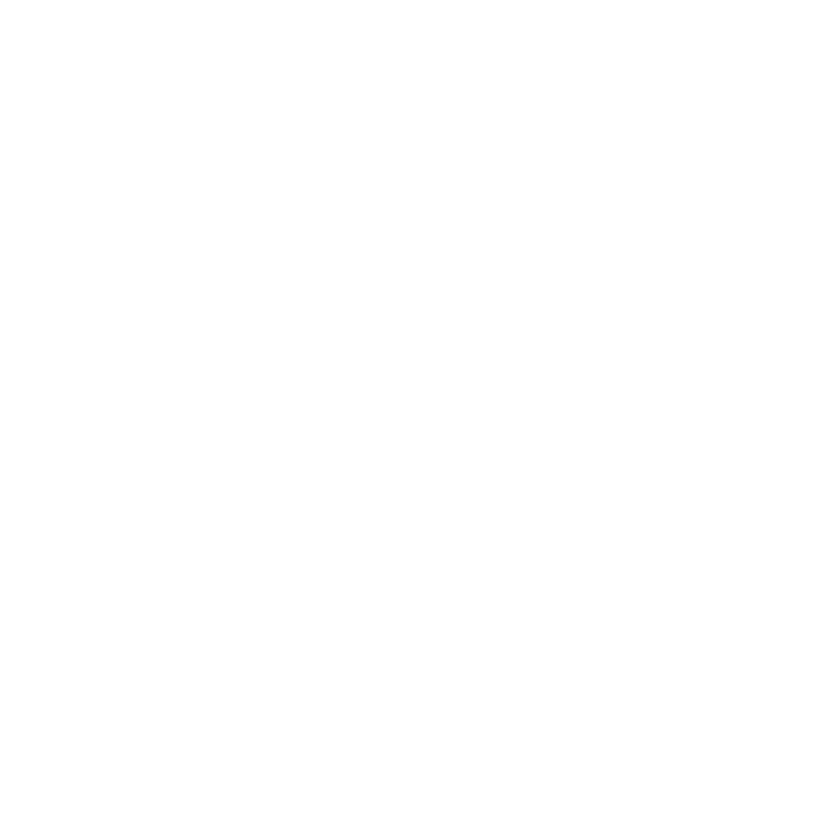

In [6]:
rejects %>% 
    ggplot(aes(steps)) + 
    geom_histogram() + 
    facet_grid(PRNG~algorithm) +
    ggtitle("Steps until rejection")